In [1]:
# подключаем библиотеки
%matplotlib inline
import json
import os
import glob
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

base_path = "/vagrant/tests/loadtests"

def path_logs(folder):
    all_subdirs = [os.path.join(base_path, folder, d) for d in os.listdir(os.path.join(base_path, folder)) if os.path.isdir(os.path.join(base_path, folder, d))]
    latest_subdir = max(all_subdirs, key=os.path.getmtime)
    return glob.glob(latest_subdir + '/phout_*.log')[0], latest_subdir + '/monitoring.log'

In [2]:
def request_graph(path_to_log):
    # импортируем пхаут
    phout_columns = [
        'time', 'tag', 'interval_real',
        'connect_time', 'send_time',
        'latency', 'receive_time',
        'interval_event', 'size_out',
        'size_in', 'net_code', 'proto_code']
    data = pd.read_csv(
        path_to_log,
        sep='\t', names=phout_columns)
    # хитрые манипуляции с колонками:
    # высчитываем время получения - будем группировать по нему (заводим новую колонку)
    data['ts'] = data.time + data.interval_real / 1000000
    # округляем до секунды
    data['receive_sec'] = data.ts.astype(int)
    # и индексируем по этой секунде
    data.set_index(['receive_sec'], inplace=True)
    # для удобства посчитаем респонс тайм в миллисекундах
    data['rt_ms'] = data.interval_real / 1000
    # группируем по индексу, считаем и рисуем график
    data[:10]
    data.groupby(level=0).count().time.plot(title="RPS")
    plt.show()
    # группируем по индексу, считаем разные агрегаты и рисуем график
    data.groupby(level=0).rt_ms.agg([np.mean, np.std, np.median]).plot(title='delay')
    plt.show()
    data = data.proto_code.groupby(level=0).value_counts()
    data = data.unstack(level=1).fillna(0)
    data.plot(title='http codes')
    plt.show()

def system_graph(path_to_log):
    columns = ['timestamp', 'memory_used', 'num_fd', 'cpu']
    data = []
    with open(path_to_log) as f:
        for line in f:
            if line == "[]\n":
                continue
            raw = json.loads(line)[0]
            timestamp = raw['timestamp']
            memory_used = float(raw['data'].values()[0]['metrics']['Memory_used']) / 10**6
            num_fd = raw['data'].values()[0]['metrics']['custom:None']
            cpu = 100 - raw['data'].values()[0]['metrics'].get('custom:cpu-cpu-total_usage_idle', 100.)
            data.append([timestamp, memory_used, num_fd, cpu])
    data = pd.DataFrame(data=data, columns=columns)
    data.set_index(['timestamp'], inplace=True)
    for i in columns[1:]:
        data[i].plot(title=i)
        plt.show()

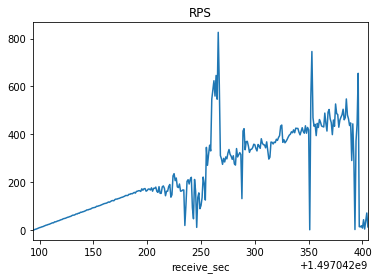

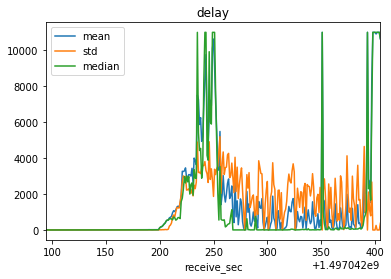

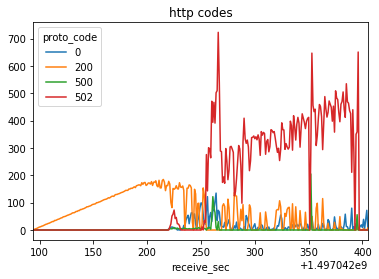

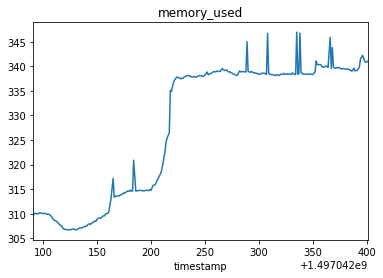

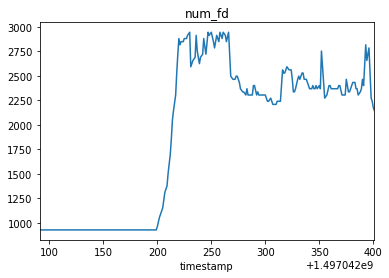

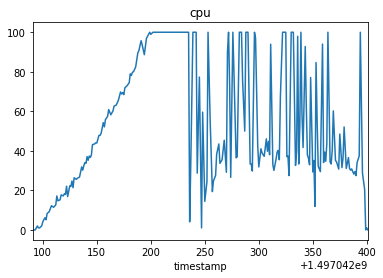

In [3]:
# authorisation sha256
a, b = path_logs('authsha256')
request_graph(a)
system_graph(b)

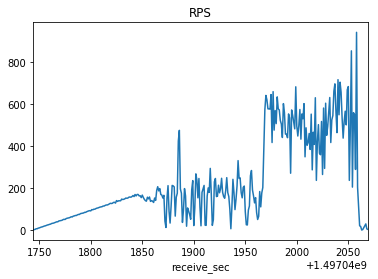

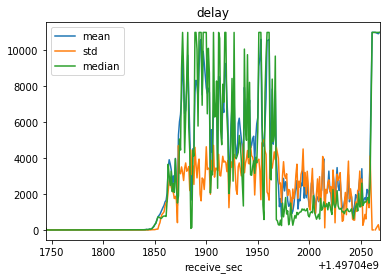

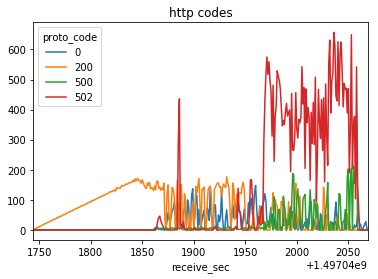

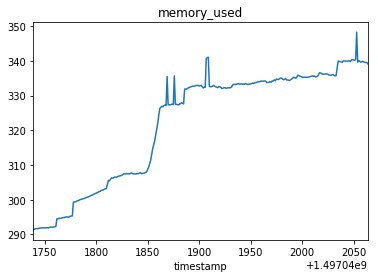

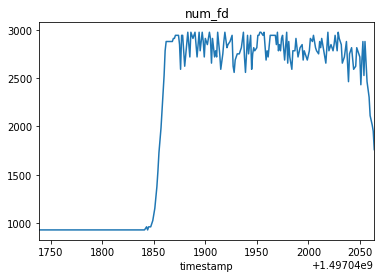

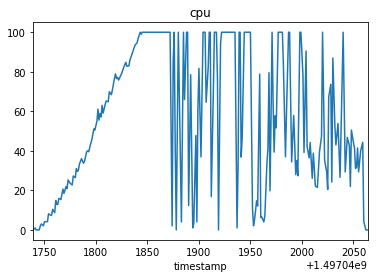

In [4]:
# authorisation pbkdf2
a, b = path_logs('authpbkdf2')
request_graph(a)
system_graph(b)

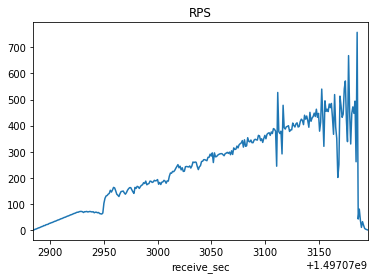

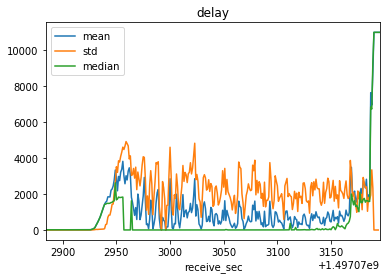

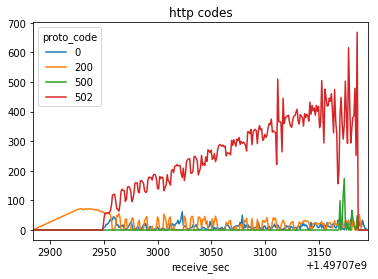

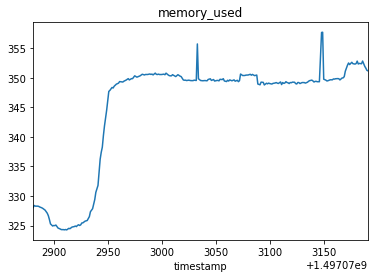

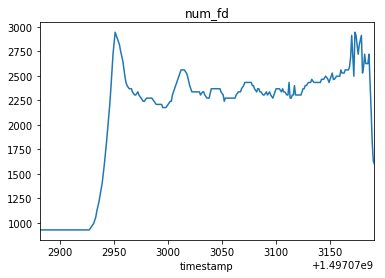

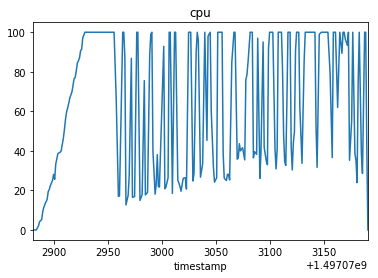

In [5]:
# calc
a,b = path_logs('calc')
request_graph(a)
system_graph(b)

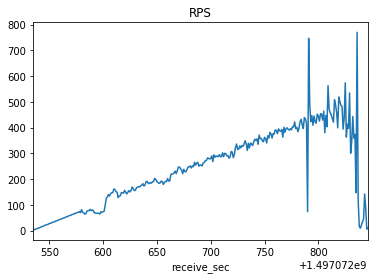

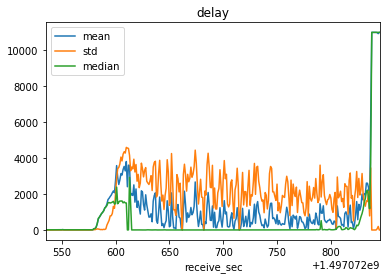

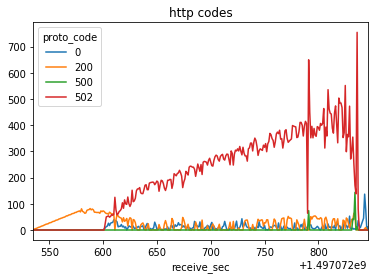

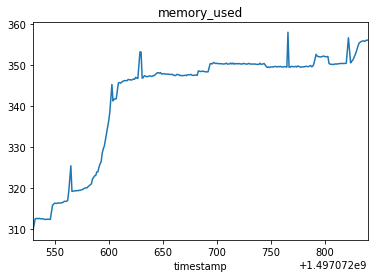

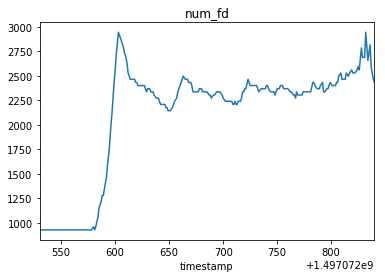

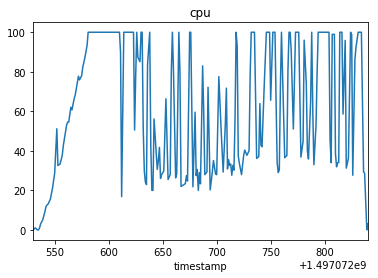

In [6]:
# fast
a,b = path_logs('fast')
request_graph(a)
system_graph(b)

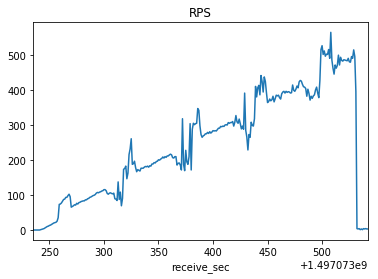

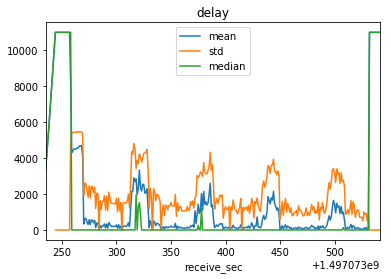

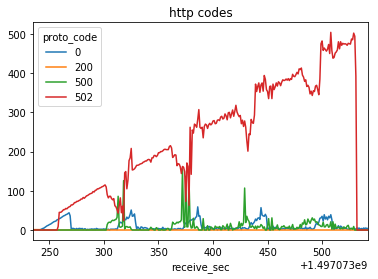

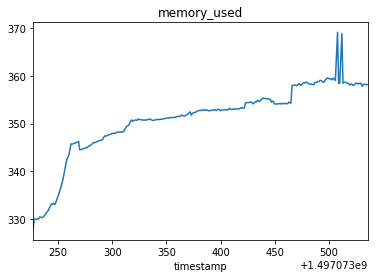

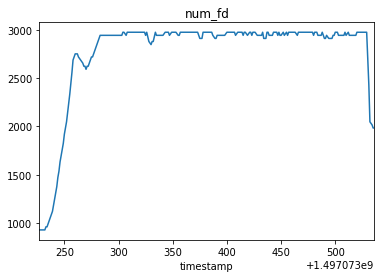

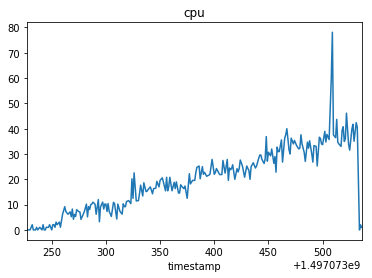

In [7]:
# ping
a,b = path_logs('ping')
request_graph(a)
system_graph(b)

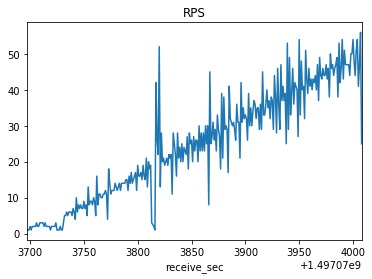

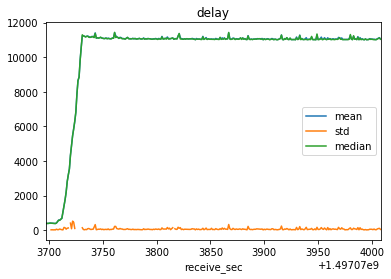

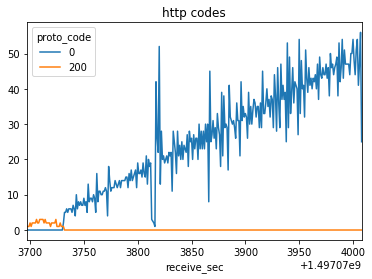

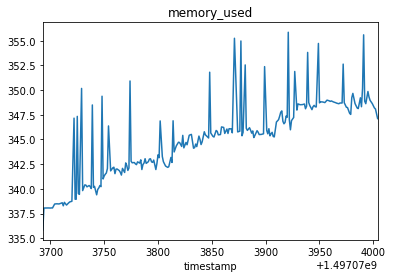

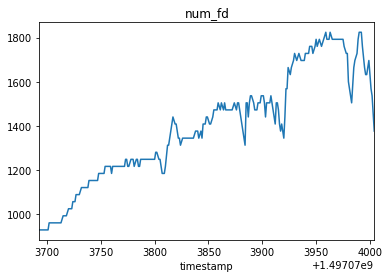

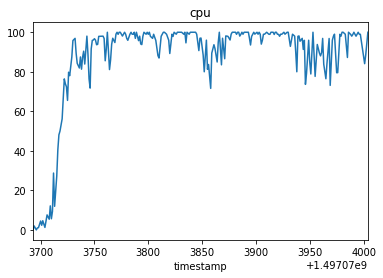

In [8]:
# nginx
a,b = path_logs('bigfiles80')
request_graph(a)
system_graph(b)

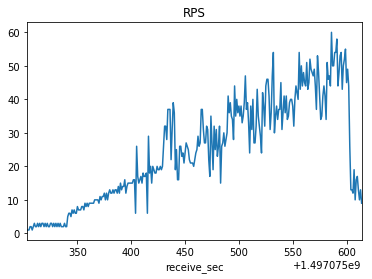

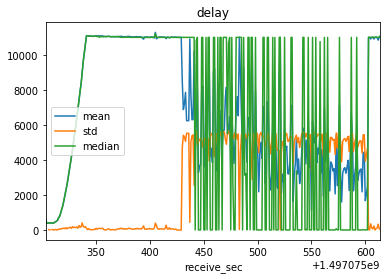

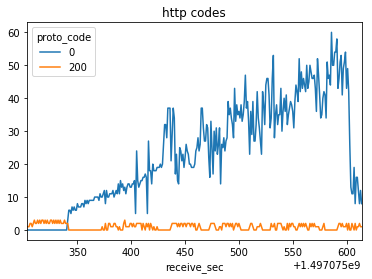

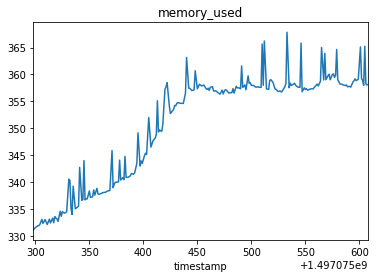

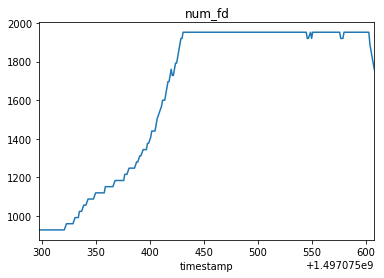

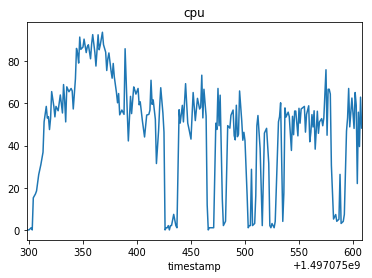

In [9]:
# server
a,b = path_logs('bigfiles8080')
request_graph(a)
system_graph(b)

#### Немного о реализации сервера

Сервер написан на bottle, запущенный через uwsgi, который синхронно обрабатывает входящие запросы. В качестве базы данных используется in memmory data base или другими словами обычный Map, поэтому при работе с базой данных отсутсвуют какие-либо блокировки.

#### Тест 1: sha256 vs pbkdf2

Как видно из графиков возвращаемых кодов, sha256 после 200 RPS количество кодов 200 довольно резко стремится в 0, в то же время RPS продолжает расти возвращая 502 код, при использовании pbkdf2 количество кодов 200 становится после 200 RPS становится нестабильным и какое-то время сервер пытается обработать соединения, однако в конечном счете тоже почти всегда возвращает 502 код

#### Тест 2: вычислительная задача

Видно что до 100 запросов сервер утилизирует мощности CPU почти на 100% реально выполняя вычислиения, после 100 рост количества обработанных запросов продолжает расти вплодь до 700, однако почти все из них имеют код 502.

#### Тест 3: быстрые задачи

Графики для этой задачи очень похожи на графики из предыдущего теста: до 100 RPS запросы обрабатываются преимущественно с кодом 200, после - 502

#### Тест 4: пинг

Можно заметить, что в тесте не используется более 3000 дескриптеров и графики довольно ступеньчаты, это из-за того, чт о в какой-то момент происходит сбор соединений. В целом, пиковая производительность достигла 500 RPS

#### Тест 5: файлы

На 80 порте работал nginx, а на 8080 - сервер. С базовым конфигом с ростом RPS nginx перестал отдавать файлы, bottle же отдавал хоть иногда (в силу снхронности, кто первый того и тапки)